In [141]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

In [142]:
CWD = os.getcwd()
DATA_PATH = r'C:\Users\andre\OneDrive\Documentos\BOOTCAMP\Capstone Project\capstone2030\data_cluster\df_cluster_estatico.xlsx'
ruta_data = os.path.join(CWD, DATA_PATH)

# EDA

In [143]:
df = pd.read_excel(ruta_data)
df.head(2)

,ID_Country,Index_year,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
0,EU,2019,71.109295,81.149563,62.572811,64.923824,51.619748,87.771101
1,BE,2019,74.066433,88.290670,71.285742,65.284090,55.196669,86.288479


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID_Country  196 non-null    object 
 1   Index_year  196 non-null    int64  
 2   WORK        196 non-null    float64
 3   MONEY       196 non-null    float64
 4   KNOWLEDGE   196 non-null    float64
 5   TIME        196 non-null    float64
 6   POWER       196 non-null    float64
 7   HEALTH      196 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 12.4+ KB


In [145]:
df.isnull().sum()

ID_Country    0
Index_year    0
WORK          0
MONEY         0
KNOWLEDGE     0
TIME          0
POWER         0
HEALTH        0
dtype: int64

In [146]:
# VER SI HAY DUPLICADOS
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Número de filas duplicadas : {num_duplicates}")


Número de filas duplicadas : 0


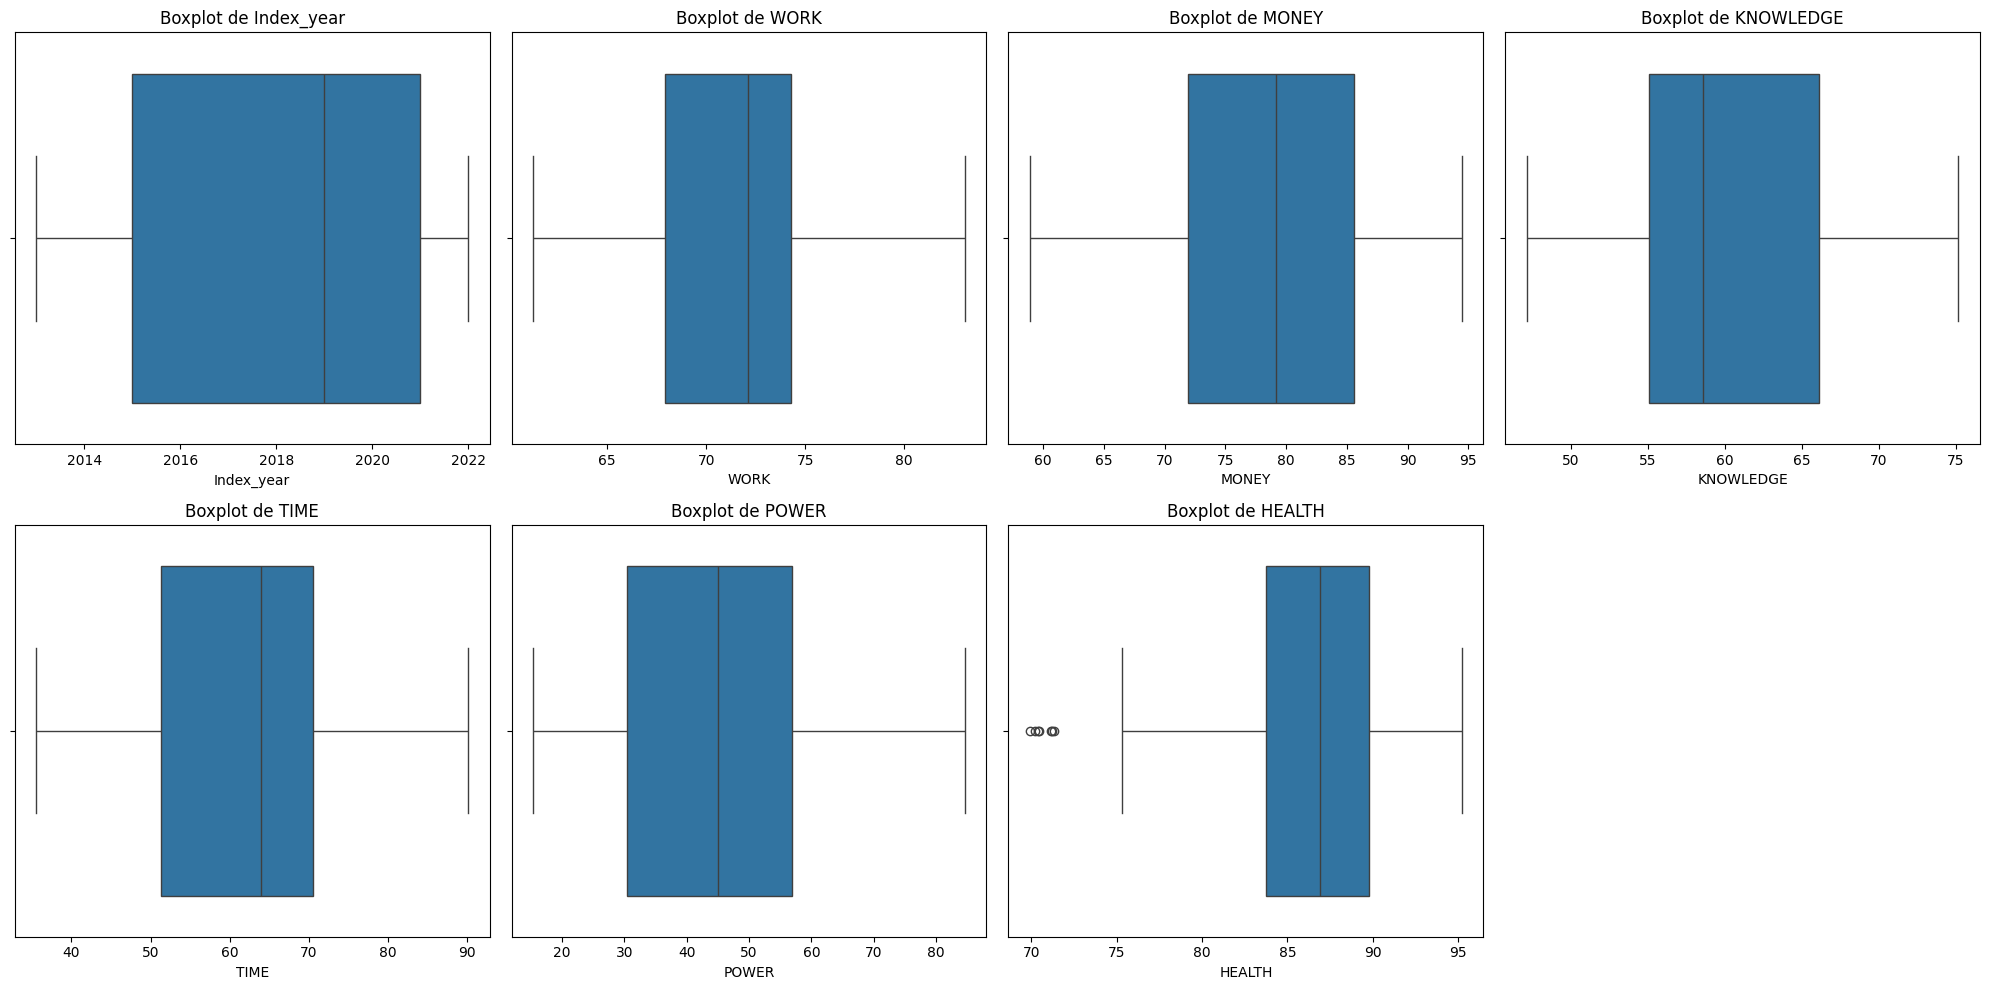

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
# DETECTAR OUTLIERS
num_columns = len(df.select_dtypes(include=['float64', 'int64']).columns)
cols = 4
rows = (num_columns + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    row = i // cols
    col = i % cols
    sns.boxplot(x=df[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot de {column}')


for j in range(i+1, rows*cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


# **PREPARAR EL DATASET PARA EL MODELO DE CLUSTERING**

In [148]:
print(df['Index_year'].max())

2022


In [149]:
df["Index_year"] = pd.to_datetime(df["Index_year"], format = "%Y")
df["Index_year"] = df["Index_year"].dt.year
df_22 = df[df["Index_year"]==2022]
print("__________________________!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("- Pasamos la fecha Index_Year del año a formato 'DATE' time y a 'AÑO' \n- Filtramos dataset por año 2022, el última que hay que analizar")



__________________________!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
- Pasamos la fecha Index_Year del año a formato 'DATE' time y a 'AÑO' 
- Filtramos dataset por año 2022, el última que hay que analizar


In [150]:
df_22.head()

,ID_Country,Index_year,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
56,EU,2022,71.670033,82.572537,62.456444,64.923824,57.237474,88.702389
57,BE,2022,75.484814,89.841750,70.137544,65.284090,67.032948,88.475969
58,BG,2022,69.253609,65.040323,56.197061,42.653851,62.989528,78.039629
59,CZ,2022,67.052387,78.954562,58.887165,57.271522,29.686283,84.836699
60,DK,2022,79.484545,88.525433,69.343523,83.093783,69.256244,89.535645


In [151]:
df_22 = df_22.drop(['Index_year'], axis=1)
print("- Eliminamos la columna Index_year ya que todo ahora es 2022")

- Eliminamos la columna Index_year ya que todo ahora es 2022


In [152]:
df_22_EU = df_22.loc[df_22['ID_Country'] == 'EU']
print("Guardamos los datos de la media de EU para añadir tras pasar los paises por el modelo y poder comparar")
df_22_EU.head()

Guardamos los datos de la media de EU para añadir tras pasar los paises por el modelo y poder comparar


,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
56,EU,71.670033,82.572537,62.456444,64.923824,57.237474,88.702389


In [153]:
df_22 = df_22.loc[df_22['ID_Country'] != 'EU']

print("- Eliminamos la linea EU ya que no es un país sino la media")
print(df.shape)
print(df_22.shape)

- Eliminamos la linea EU ya que no es un país sino la media
(196, 8)
(27, 7)


In [154]:
df_22[df_22['ID_Country']=='EU']

,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH


In [155]:
df_22.tail()

,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
79,RO,67.291435,70.159261,52.205162,50.268992,32.615388,70.399835
80,SI,73.399299,83.898613,56.014041,72.868881,53.304547,86.924949
81,SK,66.487604,74.813419,60.922184,46.259001,31.445081,85.166218
82,FI,75.427351,87.504260,61.519285,77.365551,74.287453,92.608209
83,SE,82.994741,85.895786,74.580922,90.089399,84.617613,95.205487


In [156]:
df_22.set_index('ID_Country', inplace=True)
print('El modelo KMeans no acepta objetcs, así que pasamos el ID_Country al índice para que no lo considere')

El modelo KMeans no acepta objetcs, así que pasamos el ID_Country al índice para que no lo considere


In [157]:
from sklearn.preprocessing import StandardScaler
df_modelo = df_22
# Normalización de las variables
scaler = StandardScaler()
df_modelo_scaled = scaler.fit_transform(df_modelo)
print("__________________________!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("- Tenemos dataset agrupado y sin string ID_Country \n- Estandarizamos el resto de variables para que tengan la misma escala en nuevo dataset")
df_modelo_scaled.head(4)

__________________________!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
- Tenemos dataset agrupado y sin string ID_Country 
- Estandarizamos el resto de variables para que tengan la misma escala en nuevo dataset


,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
ID_Country,,,,,,
BE,0.618270,1.367988,1.460733,0.225520,0.807602,0.273808
BG,-0.704843,-2.076467,-0.722860,-1.566806,0.578387,-1.694770
CZ,-1.172242,-0.144039,-0.301491,-0.409079,-1.309525,-0.412657
DK,1.467559,1.185176,1.336360,1.636057,0.933637,0.473692


# **CURVA DE CODO Y MODELO KMEAN**

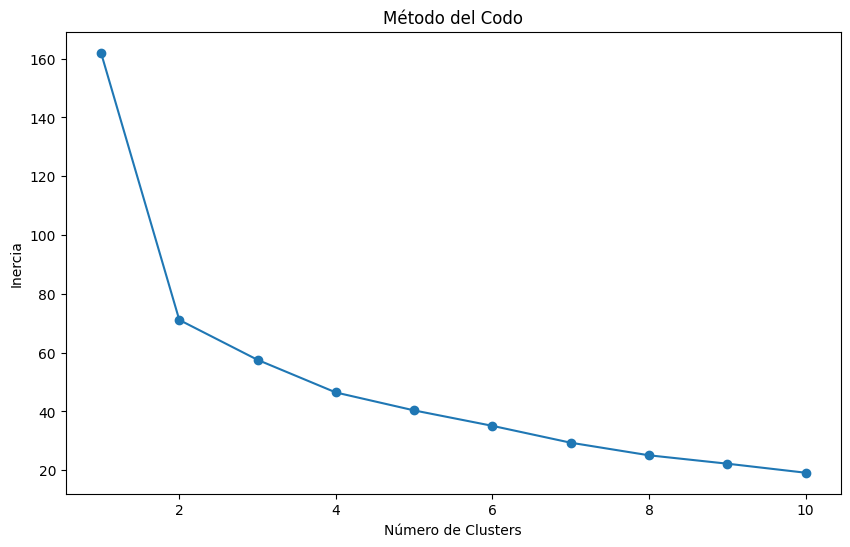

In [158]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Método del codo para encontrar el número óptimo de clusters
inertia = []
for i in range(1, 11):
    df_modelo_scaled_clust = KMeans(n_clusters=i, random_state=0)
    df_modelo_scaled_clust.fit(df_modelo_scaled)
    inertia.append(df_modelo_scaled_clust.inertia_)

# Visualizar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()



In [159]:
# El número óptimo de clusters es 'k'
k = 5
modelo_scaled_clust = KMeans(n_clusters=k, random_state=42)
clusters = modelo_scaled_clust.fit_predict(df_modelo_scaled)

df_22['cluster'] = clusters
print("Aplicamos el modelo Kmeans agrupado en ",k, " clusters al dataset agrupado para los",df_22['cluster'].value_counts().sum(), " paises:\n",df_22['cluster'].value_counts())

Aplicamos el modelo Kmeans agrupado en  5  clusters al dataset agrupado para los 27  paises:
 cluster
1    8
2    6
0    5
4    4
3    4
Name: count, dtype: int64


# **ANÁLISIS AGRUPACIÓN CLUSTERS TRAS MODELO**

In [160]:
# pip install openpyxl
# para poder descargar datasets individualmente

In [161]:
df_index = df_22.reset_index()
print('Reseteamos el índice para que ID_PAIS vuelva a ser variable con la nueva variables CLUSTER')
df_index.head()

Reseteamos el índice para que ID_PAIS vuelva a ser variable con la nueva variables CLUSTER


,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH,cluster
0,BE,75.484814,89.841750,70.137544,65.284090,67.032948,88.475969,0
1,BG,69.253609,65.040323,56.197061,42.653851,62.989528,78.039629,2
2,CZ,67.052387,78.954562,58.887165,57.271522,29.686283,84.836699,1
3,DK,79.484545,88.525433,69.343523,83.093783,69.256244,89.535645,4
4,DE,72.866633,83.457074,54.666322,65.019657,64.814086,90.014615,0


In [162]:
grouped_countries = df_index.groupby('cluster')['ID_Country'].apply(lambda x: ', '.join(x)).reset_index()

grouped_countries

,cluster,ID_Country
0,0,"BE, DE, ES, FR, FI"
1,1,"CZ, EE, GR, IT, CY, HU, PL, SK"
2,2,"BG, HR, LV, LT, PT, RO"
3,3,"LU, MT, AT, SI"
4,4,"DK, IE, NL, SE"


In [163]:
df_index_grouped = df_index.groupby('cluster')[['WORK', 'MONEY', 'KNOWLEDGE', 'TIME', 'POWER', 'HEALTH']].mean()
print("Distribución variables por clusters que realizó el modelo")
df_index_grouped.style.background_gradient(cmap = 'Blues', axis = 0)

Distribución variables por clusters que realizó el modelo


,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
cluster,,,,,,
0,74.117764,84.843390,64.030924,67.792098,73.686992,90.279567
1,67.466673,76.955659,58.099655,55.043550,33.768192,85.974914
2,71.281794,70.634198,53.974933,51.309520,49.519378,80.013839
3,75.957069,86.901092,63.529444,66.855456,51.265988,89.115683
4,79.407908,87.126046,69.750793,82.800310,71.119632,93.478868


## **1. ANALISIS CLUSTERS CON MEDIA EU**

Vemos una agrupación basada principalmente en lo bien o mal que están respecto la media de EU.

Es una agrupación de "peor a mejor"

In [164]:
df_22_EU['cluster'] = 'EU'
print("Recuperamos variable cluster con nombre EU para juntar los 2 datasets [df_index tras el modelo y el df_22_EU ] y lo que sale del modelo y la media Europea los unimos")
df_22_EU.head()

Recuperamos variable cluster con nombre EU para juntar los 2 datasets [df_index tras el modelo y el df_22_EU ] y lo que sale del modelo y la media Europea los unimos


,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH,cluster
56,EU,71.670033,82.572537,62.456444,64.923824,57.237474,88.702389,EU


In [165]:
df_index_EU = df_index['cluster'].astype('object')
df_index_EU =  pd.concat([df_index, df_22_EU])
df_index_EU.tail()

,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH,cluster
23,SI,73.399299,83.898613,56.014041,72.868881,53.304547,86.924949,3
24,SK,66.487604,74.813419,60.922184,46.259001,31.445081,85.166218,1
25,FI,75.427351,87.504260,61.519285,77.365551,74.287453,92.608209,0
26,SE,82.994741,85.895786,74.580922,90.089399,84.617613,95.205487,4
56,EU,71.670033,82.572537,62.456444,64.923824,57.237474,88.702389,EU


In [166]:
# Cluster 0: BG (Bulgaria), EE (Estonia), HR (Croacia), LV (Letonia), LT (Lituania), PT (Portugal), RO (Rumania) --> Peores países todo a mejorar. Por debajo media EU en todo. Solo igualdad en Work. Son los que tienen mejor evol en Money
# Cluster 1: DE (Alemania), MT (Malta), AT (Austria), SI (Eslovenia) --> Paises con buena media, pero que tienen que mejorar Knowleadge y Power
# Cluster 2: CZ (República Checa), GR (Grecia), IT (Italia), CY (Chipre), HU (Hungría), PL (Polonia), SK (Eslovaquia) --> Peores países con Money y Health en proceso de mejora.
# Cluster 3: DK (Dinamarca), IE (Irlanda), NL (Países Bajos), FI (Finlandia), SE (Suecia) --> Mejores paises en terminos igualdad
# Cluster 4: BE (Bélgica), ES (España), FR (Francia), LU (Luxemburgo) --> Paises por encima media, con opciones de mejora en WORK, TIME y HEALTH.

In [167]:
# Cluster 0: Peores países, con solo igualdad laboral
# Cluster 1: Paises con buena media, pero que tienen que mejorar Knowleadge y Power
# Cluster 2: Peores países con Money y Health en proceso de mejora.
# Cluster 3: Mejores paises
# Cluster 4: Paises por encima media, con opciones de mejora en WORK, TIME y HEALTH.

In [168]:
cambio_nombre_cluster = {
    0: 'In development',
    1: 'In the middle',
    2: 'Bottom Countries',
    3: 'Top Countries',
    4: 'Road to the Top',
}

# Reemplazar los valores en la columna 'cluster'
df_index_EU['cluster'] = df_index_EU['cluster'].replace(cambio_nombre_cluster)
print('cambiamos nombre clusters')
df_index_EU.head()

cambiamos nombre clusters


,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH,cluster
0,BE,75.484814,89.841750,70.137544,65.284090,67.032948,88.475969,In development
1,BG,69.253609,65.040323,56.197061,42.653851,62.989528,78.039629,Bottom Countries
2,CZ,67.052387,78.954562,58.887165,57.271522,29.686283,84.836699,In the middle
3,DK,79.484545,88.525433,69.343523,83.093783,69.256244,89.535645,Road to the Top
4,DE,72.866633,83.457074,54.666322,65.019657,64.814086,90.014615,In development


In [169]:
# # PARA IMPORTAR A EXCEL
# from google.colab import files
# excel_file = 'df_index_EU.xlsx'
# df_index_EU.to_excel(excel_file, index=False, engine='openpyxl')
# files.download(excel_file)

In [170]:
grouped_clusters = df_index_EU.groupby('cluster')[['WORK', 'MONEY','KNOWLEDGE','TIME','POWER','HEALTH']].mean()
grouped_clusters.style.background_gradient(cmap = 'Blues', axis = 0)

,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH
cluster,,,,,,
Bottom Countries,71.281794,70.634198,53.974933,51.309520,49.519378,80.013839
EU,71.670033,82.572537,62.456444,64.923824,57.237474,88.702389
In development,74.117764,84.843390,64.030924,67.792098,73.686992,90.279567
In the middle,67.466673,76.955659,58.099655,55.043550,33.768192,85.974914
Road to the Top,79.407908,87.126046,69.750793,82.800310,71.119632,93.478868
Top Countries,75.957069,86.901092,63.529444,66.855456,51.265988,89.115683


In [171]:
df_index_simplificado = grouped_clusters
df_index_simplificado['Media_Total'] = df_index_simplificado.mean(axis=1)
df_index_simplificado['Media_Total'].to_frame().style.background_gradient(cmap='Blues')


,Media_Total
cluster,
Bottom Countries,62.788944
EU,71.260450
In development,75.791789
In the middle,62.884774
Road to the Top,80.613926
Top Countries,72.270789


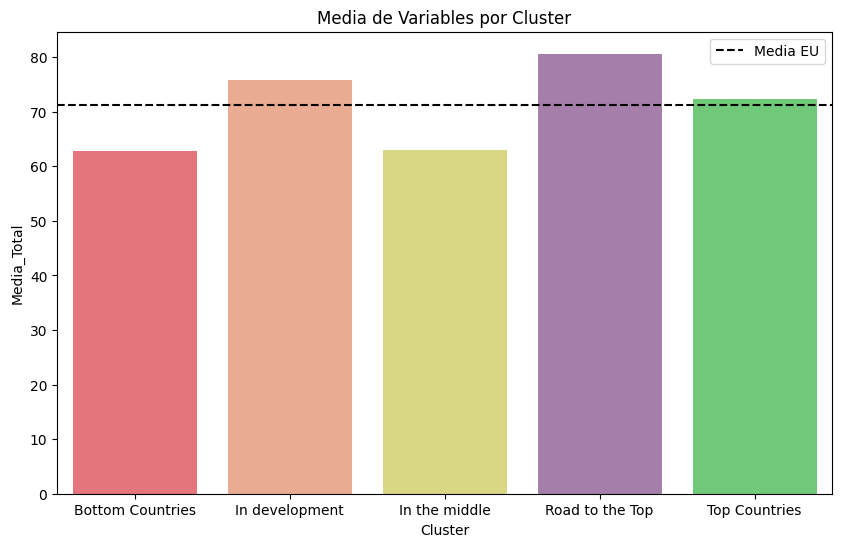

In [172]:
df_index_simplificado_no_eu = df_index_simplificado[df_index_simplificado.index != 'EU']
df_index_simplificado_solo_eu = df_index_simplificado.loc['EU']

colores = {
    'In development':"#F8A683" ,
    'In the middle':"#E7E376",
    'Bottom Countries':"#F7626C" ,
    'Top Countries':"#61D76D" ,
    'Road to the Top': "#AB78B0" ,
}

plt.figure(figsize=(10, 6))
sns.barplot(data=df_index_simplificado_no_eu, x=df_index_simplificado_no_eu.index, y='Media_Total', palette=colores)
plt.axhline(y=df_index_simplificado_solo_eu['Media_Total'], color='k', linestyle='--', label='Media EU')

plt.title('Media de Variables por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Media_Total')
plt.legend()
plt.show()

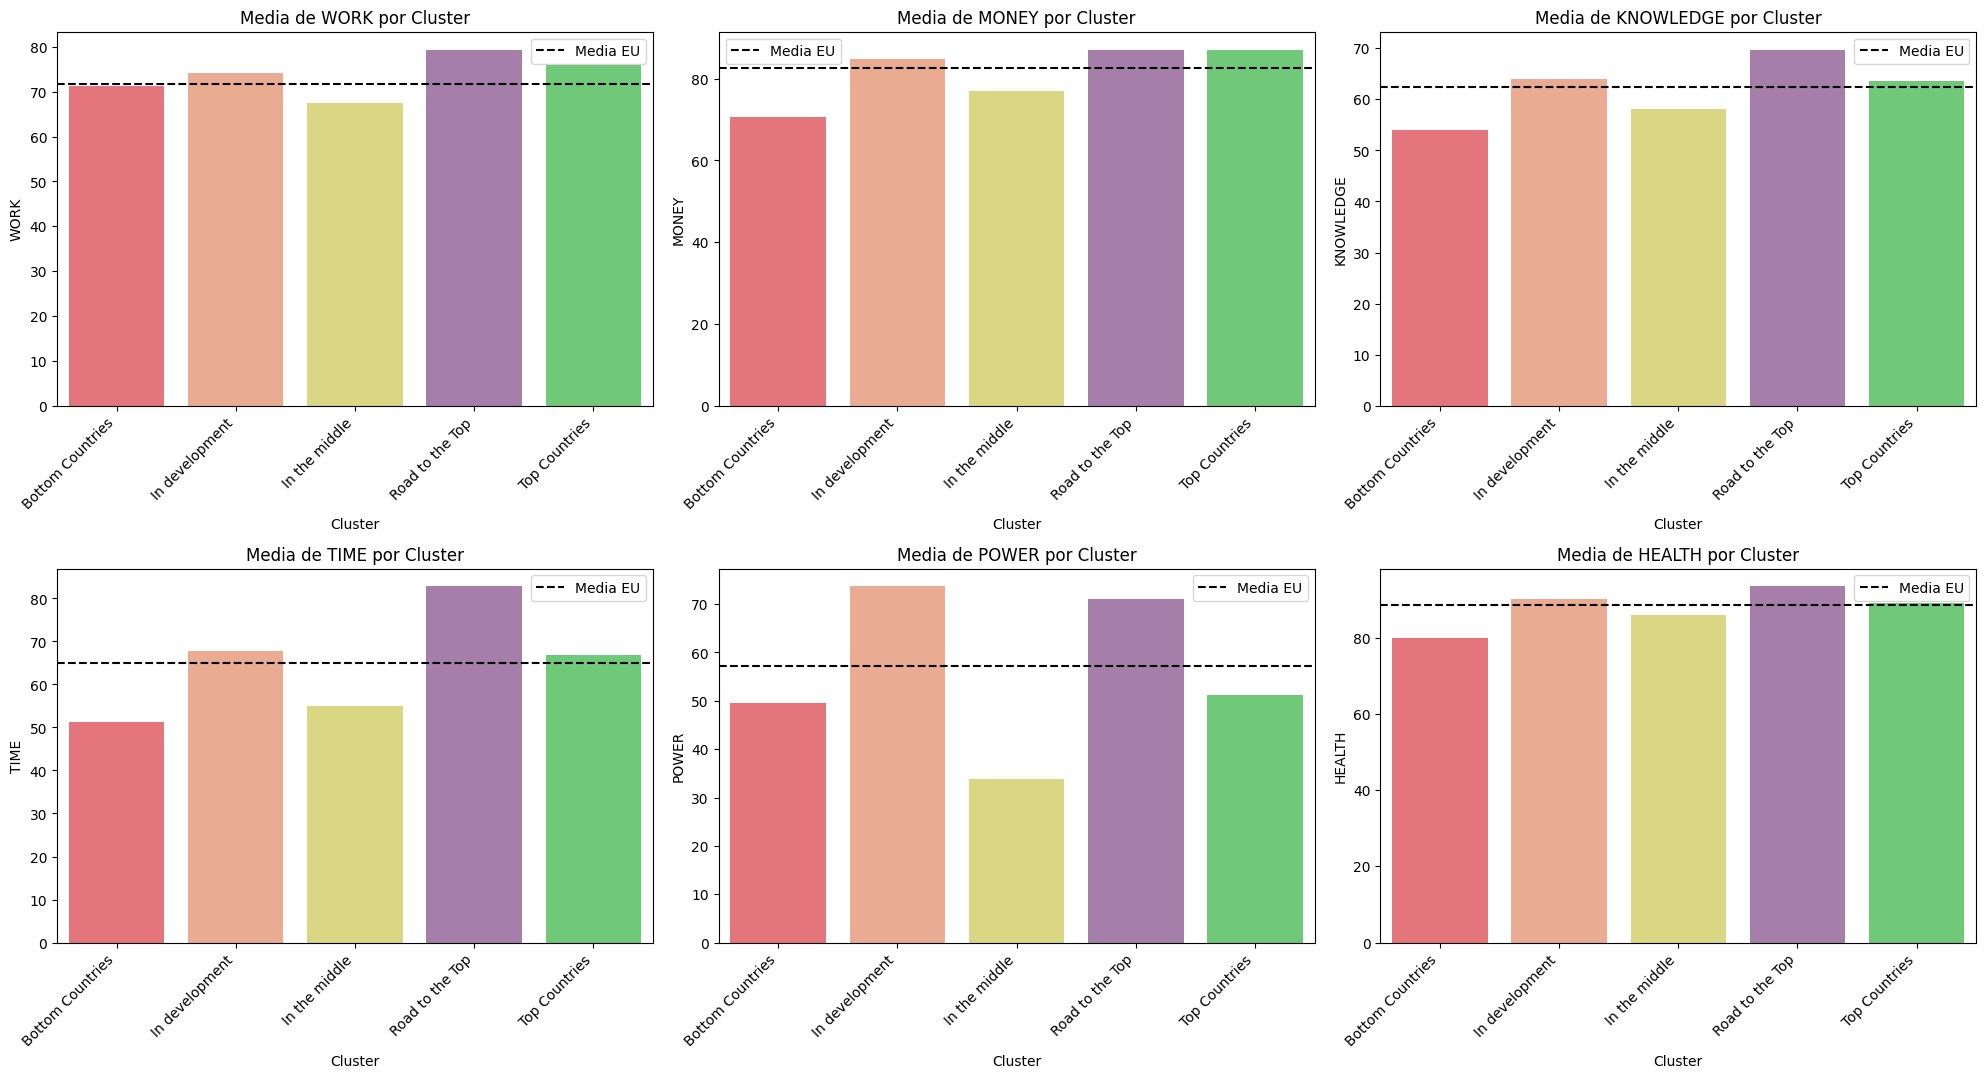

In [173]:
#grouped_clusters = df_index_EU.groupby('cluster')['WORK', 'MONEY','KNOWLEDGE','TIME','POWER','HEALTH'].mean()

# Extraer las medias EU para ponerla como comparativa fuera de las columnas
eu_means_1 = grouped_clusters.loc['EU'] if 'EU' in grouped_clusters.index else df_index_EU[['WORK', 'MONEY','KNOWLEDGE','TIME','POWER','HEALTH']].mean()

# Filtrar el DataFrame para excluir el cluster 'EU'
df_index_NO_EU = df_index_EU[df_index_EU['cluster'] != 'EU']

# Calcular medias de todas las variables por cluster, excluyendo 'EU'
grouped_clusters_filtered = df_index_NO_EU.groupby('cluster')[['WORK', 'MONEY','KNOWLEDGE','TIME','POWER','HEALTH']].mean()

rows = 3  # se ve mejor con 3 que con 2
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(20, 15))  # Ajusta el tamaño según necesites

# Definir una paleta de colores específica para cada cluster, sin incluir 'EU'
cluster_color = {
    'In development':"#F8A683" ,
    'In the middle':"#E7E376",
    'Bottom Countries':"#F7626C" ,
    'Top Countries':"#61D76D" ,
    'Road to the Top': "#AB78B0" ,
}

for i, column in enumerate(grouped_clusters_filtered.columns):
    row = i // cols
    col = i % cols
    sns.barplot(x=grouped_clusters_filtered.index, y=grouped_clusters_filtered[column], ax=ax[row, col], palette=cluster_color)
    # Añadir una línea transversal para la media de 'EU'
    ax[row, col].axhline(y=eu_means_1[column], color='k', linestyle='--', label='Media EU')
    ax[row, col].set_title(f'Media de {column} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(column)
    ax[row, col].legend()
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=45, ha="right")  # Ajusta el ángulo según necesites


# Ocultar subplots vacíos si los hay
for j in range(i+1, rows*cols):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()

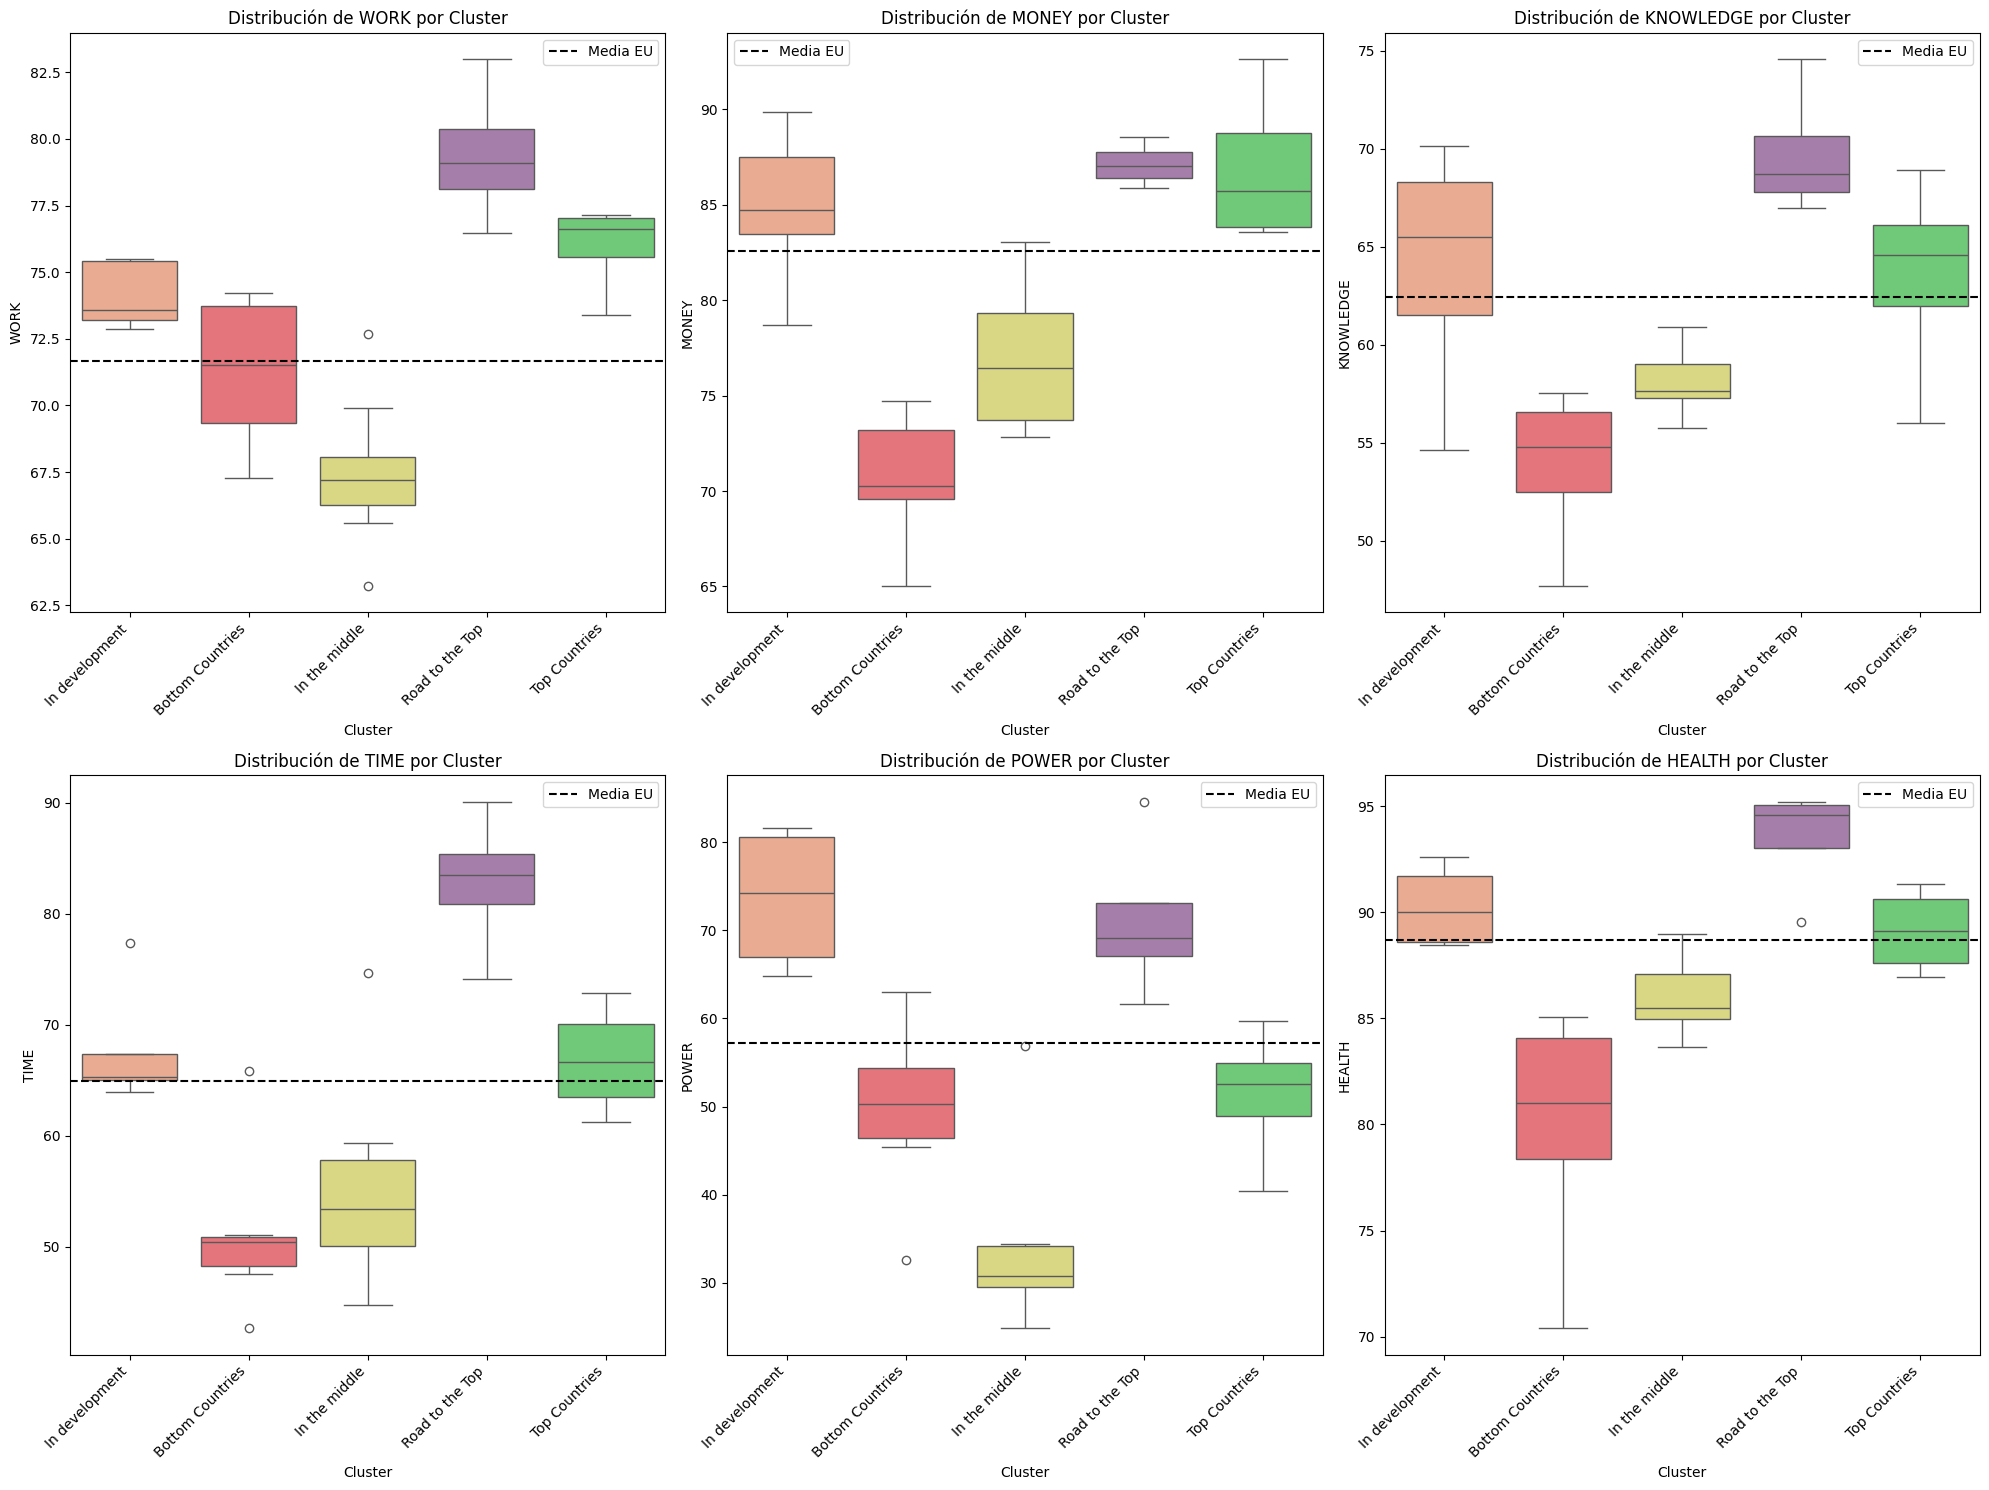

In [174]:
rows = 2
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(20, 15))  # Ajusta el tamaño según necesites

cluster_colors = {
    'In development':"#F8A683" ,
    'In the middle':"#E7E376",
    'Bottom Countries':"#F7626C" ,
    'Top Countries':"#61D76D" ,
    'Road to the Top': "#AB78B0" ,
}

variables = ['WORK', 'MONEY','KNOWLEDGE','TIME','POWER','HEALTH']  # Ajustar según las columnas correctas

for i, var in enumerate(variables):
    row = i // cols
    col = i % cols
    sns.boxplot(x='cluster', y=var, data=df_index_NO_EU, ax=ax[row, col], palette=cluster_colors)
    # Añadir una línea transversal para la media de 'EU'
    ax[row, col].axhline(y=eu_means_1[var], color='k', linestyle='--', label='Media EU')
    ax[row, col].set_title(f'Distribución de {var} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(var)
    ax[row, col].legend()
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=45, ha="right")  # Ajusta el ángulo según necesites

# Ajustar para el número de variables. Si es impar, ocultar el subplot vacío
if len(variables) % cols != 0:
    fig.delaxes(ax.flatten()[-1])

plt.tight_layout()
plt.show()

## **2. ANÁLISIS CLUSTERS AÑADIENDO LA DIFF % Vs AÑO ANTERIOR**

Cada cluster ha destacado en mejorar 1 variable respecto al año anterior

La variable tiempo se mantiene igual respecto al año anterior

In [175]:
CWD = os.getcwd()
DATA_PATH = r'C:\Users\andre\OneDrive\Documentos\BOOTCAMP\Capstone Project\capstone2030\data_cluster\df_22_evol.xlsx'
ruta_data_evol = os.path.join(CWD, DATA_PATH)

In [176]:
df_22_evol = pd.read_excel(ruta_data_evol)
print('Cargamos el dataset con el evolutivo del año anterior para juntar con el dataset del cluster y detectar tendencias')
df_combined_evol = pd.merge(df_22_evol, df_index_EU, on='ID_Country', how='left')
df_combined_evol.drop(['ID_Country','WORK',	'MONEY',	'KNOWLEDGE',	'TIME',	'POWER',	'HEALTH'], axis=1, inplace=True)
df_combined_evol = df_combined_evol.groupby('cluster').mean()
df_combined_evol.style.background_gradient(cmap = 'Blues', axis = 0)

Cargamos el dataset con el evolutivo del año anterior para juntar con el dataset del cluster y detectar tendencias


,WORK_dif,MONEY_dif,KNOWLEDGE_dif,TIME_dif,POWER_dif,HEALTH_dif
cluster,,,,,,
Bottom Countries,-0.200460,0.666113,0.102779,0.000000,2.243065,0.561080
EU,0.049031,0.148545,-0.212321,0.000000,2.240767,0.874493
In development,0.176617,-0.842333,-0.418637,0.000000,2.414837,1.418943
In the middle,-0.218566,0.344778,0.327817,0.000000,1.388447,0.394446
Road to the Top,0.104353,-0.181115,-0.511106,0.000000,2.724527,2.091524
Top Countries,0.232707,-0.133976,-0.708106,0.000000,3.249865,-1.343520


## **3. ANÁLISIS CLUSTERS CON VARIABLES EXTRA SOCIO-ECONÓMICAS**

Vemos influencia de PIB e IDH como principales indicadores de agrupación por clusters.

La Deuda no es un indicador. Tanto el mejor como el peor cluster tienen el menor % de Deuda

In [177]:
CWD = os.getcwd()
DATA_PATH = r'C:\Users\andre\OneDrive\Documentos\BOOTCAMP\Capstone Project\capstone2030\data_cluster\df_EU_info_extra.xlsx'
ruta_data_info = os.path.join(CWD, DATA_PATH)

In [178]:
##subimos informacion socio-económica extra de EU
df_EU_info_extra = pd.read_excel(ruta_data_info)
df_EU_info_extra.head()

,ID_Country,Población,PIB anual,PIB Per Capita,IDH,Deuda total (M.€),Deuda (%PIB),Déficit (%PIB)
0,Alemania,84358845.0,4121160.0,48750.0,0.942,2561675.0,0.661,-0.025
1,Austria,9104772.0,447218.0,49400.0,0.916,350698.0,0.784,-0.035
2,Bélgica,11754004.0,554044.0,47440.0,0.937,578063.0,1.043,-0.039
3,Bulgaria,6447710.0,85801.0,13270.0,0.795,19353.0,0.226,-0.029
4,Chequia,10827529.0,276266.0,25850.0,0.889,124300.0,0.442,-0.032


In [179]:
df_index_EU_updated = df_index_EU
df_EU_info_extra_updated = df_EU_info_extra

country_mapping = {"Alemania": "DE", "Austria": "AT", "Bélgica": "BE", "Bulgaria": "BG", "Chequia": "CZ", "Dinamarca": "DK", "España": "ES", "Estonia": "EE", "Finlandia": "FI", "Francia": "FR", "Grecia": "GR", "Hungría": "HU", "Irlanda": "IE", "Italia": "IT",
    "Letonia": "LV", "Lituania": "LT", "Luxemburgo": "LU", "Malta": "MT", "Países Bajos": "NL", "Polonia": "PL", "Portugal": "PT", "Rumanía": "RO", "Suecia": "SE", "EU": "EU", 'Croacia': 'HR', 'Chipre': 'CY', 'Eslovaquia': 'SK',  'Eslovenia': 'SI'
}

# Aplicar el mapeo al DataFrame df_EU_info_extra
df_EU_info_extra_updated['ID_Country'] = df_EU_info_extra_updated['ID_Country'].map(country_mapping)

# Unir los DataFrames basados en 'ID_Country'
df_combined = pd.merge(df_index_EU_updated, df_EU_info_extra_updated, on='ID_Country', how='left')
# Pasamos 'cluster' tipo categórico o string
df_combined['cluster'] = df_combined['cluster'].astype(str)  # Convertir a string

df_combined.head()

,ID_Country,WORK,MONEY,KNOWLEDGE,TIME,POWER,HEALTH,cluster,Población,PIB anual,PIB Per Capita,IDH,Deuda total (M.€),Deuda (%PIB),Déficit (%PIB)
0,BE,75.484814,89.841750,70.137544,65.284090,67.032948,88.475969,In development,11754004.0,554044.0,47440.0,0.937,578063.0,1.043,-0.039
1,BG,69.253609,65.040323,56.197061,42.653851,62.989528,78.039629,Bottom Countries,6447710.0,85801.0,13270.0,0.795,19353.0,0.226,-0.029
2,CZ,67.052387,78.954562,58.887165,57.271522,29.686283,84.836699,In the middle,10827529.0,276266.0,25850.0,0.889,124300.0,0.442,-0.032
3,DK,79.484545,88.525433,69.343523,83.093783,69.256244,89.535645,Road to the Top,5932654.0,374680.0,62990.0,0.948,113586.0,0.298,0.033
4,DE,72.866633,83.457074,54.666322,65.019657,64.814086,90.014615,In development,84358845.0,4121160.0,48750.0,0.942,2561675.0,0.661,-0.025


In [180]:
# from google.colab import files

# excel_file_2 = 'df_combined.xlsx'
# df_combined.to_excel(excel_file_2, index=False, engine='openpyxl')
# files.download(excel_file_2)

In [181]:
mean_metrics_by_cluster = df_combined.groupby('cluster')[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']].mean()
print("Después añadir variables socioeconómicas, vamos a verlas por Cluster con la media EU")
mean_metrics_by_cluster.style.background_gradient(cmap = 'Blues', axis = 0)

Después añadir variables socioeconómicas, vamos a verlas por Cluster con la media EU


,Población,PIB anual,PIB Per Capita,IDH,Deuda total (M.€),Deuda (%PIB),Déficit (%PIB)
cluster,,,,,,,
Bottom Countries,7426303.166667,131095.833333,18921.666667,0.846333,85701.833333,0.549167,-0.024500
EU,16616889.703704,605175.148148,37838.518519,0.896111,499847.111111,0.675963,-0.022789
In development,43615088.600000,1808955.400000,42672.000000,0.925400,1557750.200000,0.934200,-0.032860
In the middle,16767312.375000,428282.125000,23821.250000,0.878375,472140.250000,0.804500,-0.030125
Road to the Top,9864959.250000,619208.250000,68360.000000,0.945250,248918.000000,0.393000,0.015500
Top Countries,3106106.000000,151321.750000,57685.000000,0.920500,105029.000000,0.569250,-0.031250


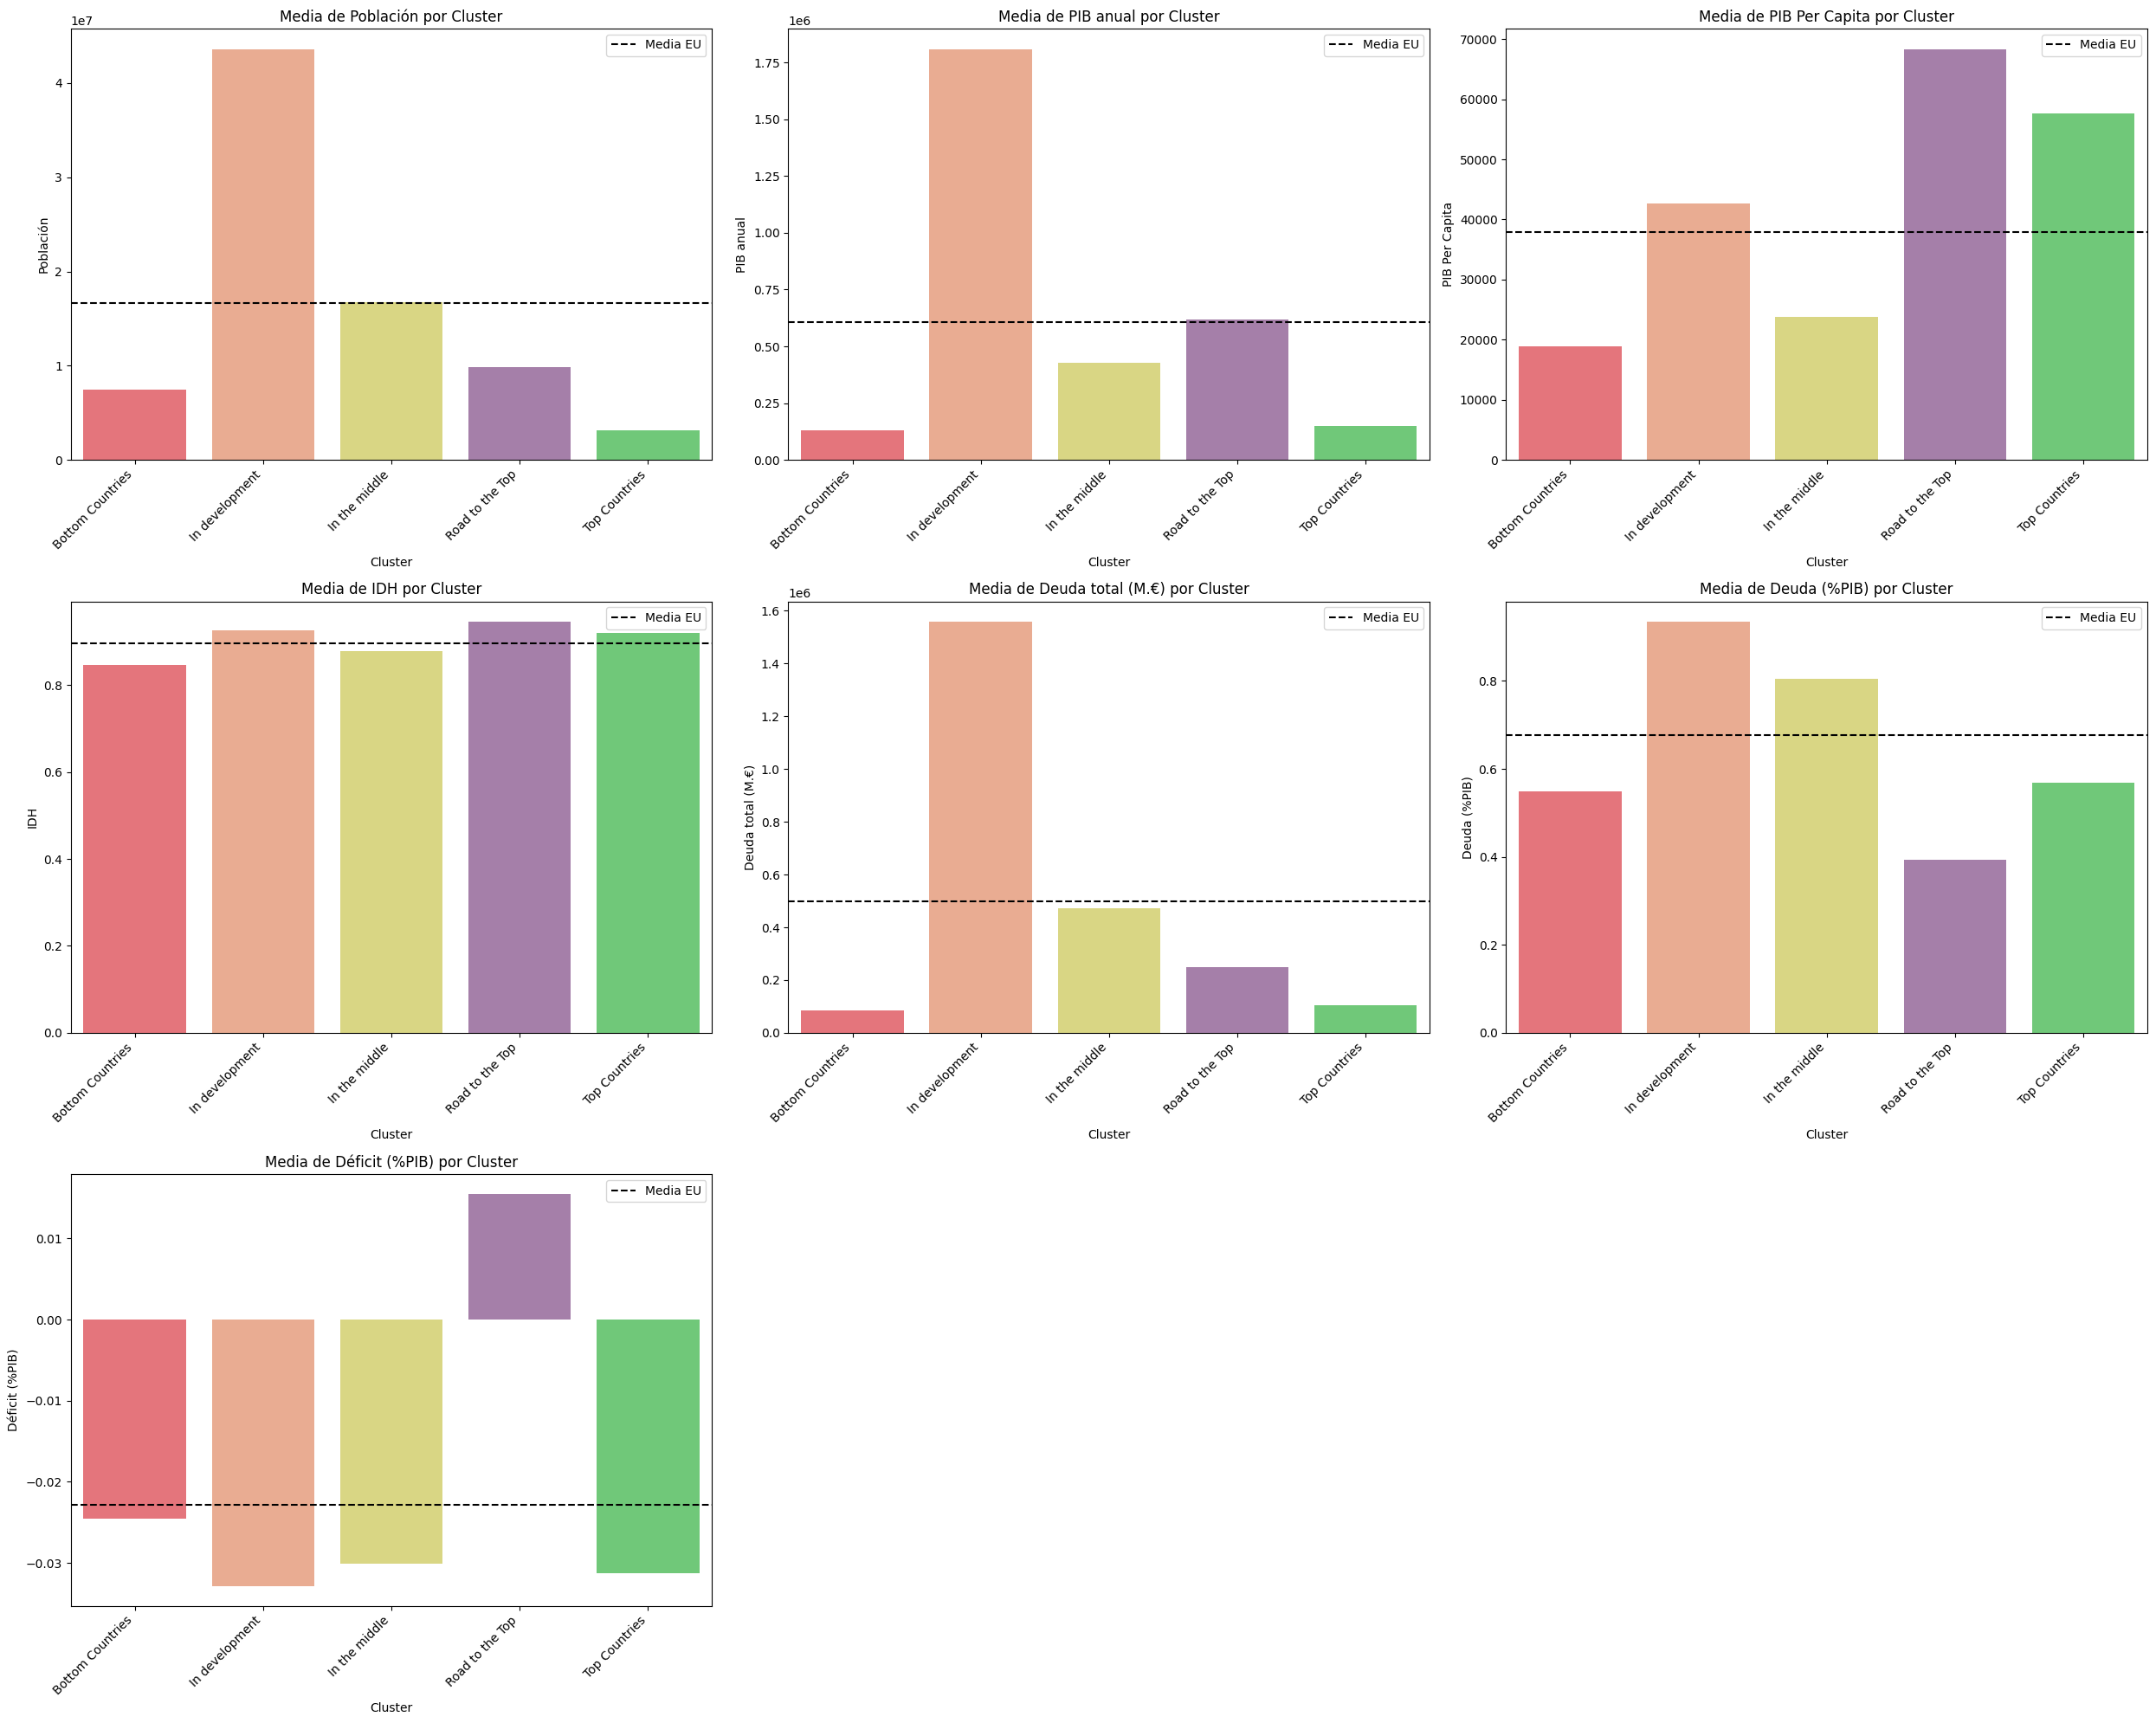

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'EU' in mean_metrics_by_cluster.index:
    eu_means = mean_metrics_by_cluster.loc['EU']
else:
    eu_means = df_combined[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']].mean()

eu_means
# Filtrar el DataFrame para excluir el cluster 'EU'
df_filtered = df_combined[df_combined['cluster'] != 'EU']

# Calcular medias de todas las variables por cluster, excluyendo 'EU'
mean_metrics_by_cluster_filtered = df_filtered.groupby('cluster')[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']].mean()

rows = 3
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(25, 20))  # Ajusta el tamaño según necesites

# Definir una paleta de colores específica para cada cluster, sin incluir 'EU'
cluster_colors = {
    'In development':"#F8A683" ,
    'In the middle':"#E7E376",
    'Bottom Countries':"#F7626C" ,
    'Top Countries':"#61D76D" ,
    'Road to the Top': "#AB78B0" ,
}

for i, column in enumerate(mean_metrics_by_cluster_filtered.columns):
    row = i // cols
    col = i % cols
    sns.barplot(x=mean_metrics_by_cluster_filtered.index, y=mean_metrics_by_cluster_filtered[column], ax=ax[row, col], palette=cluster_colors)
    # Añadir una línea transversal para la media de 'EU'
    ax[row, col].axhline(y=eu_means[column], color='k', linestyle='--', label='Media EU')
    ax[row, col].set_title(f'Media de {column} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(column)
    ax[row, col].legend()
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=45, ha="right")  # Ajusta el ángulo según necesites

# Ocultar subplots vacíos si los hay
for j in range(i+1, rows*cols):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()


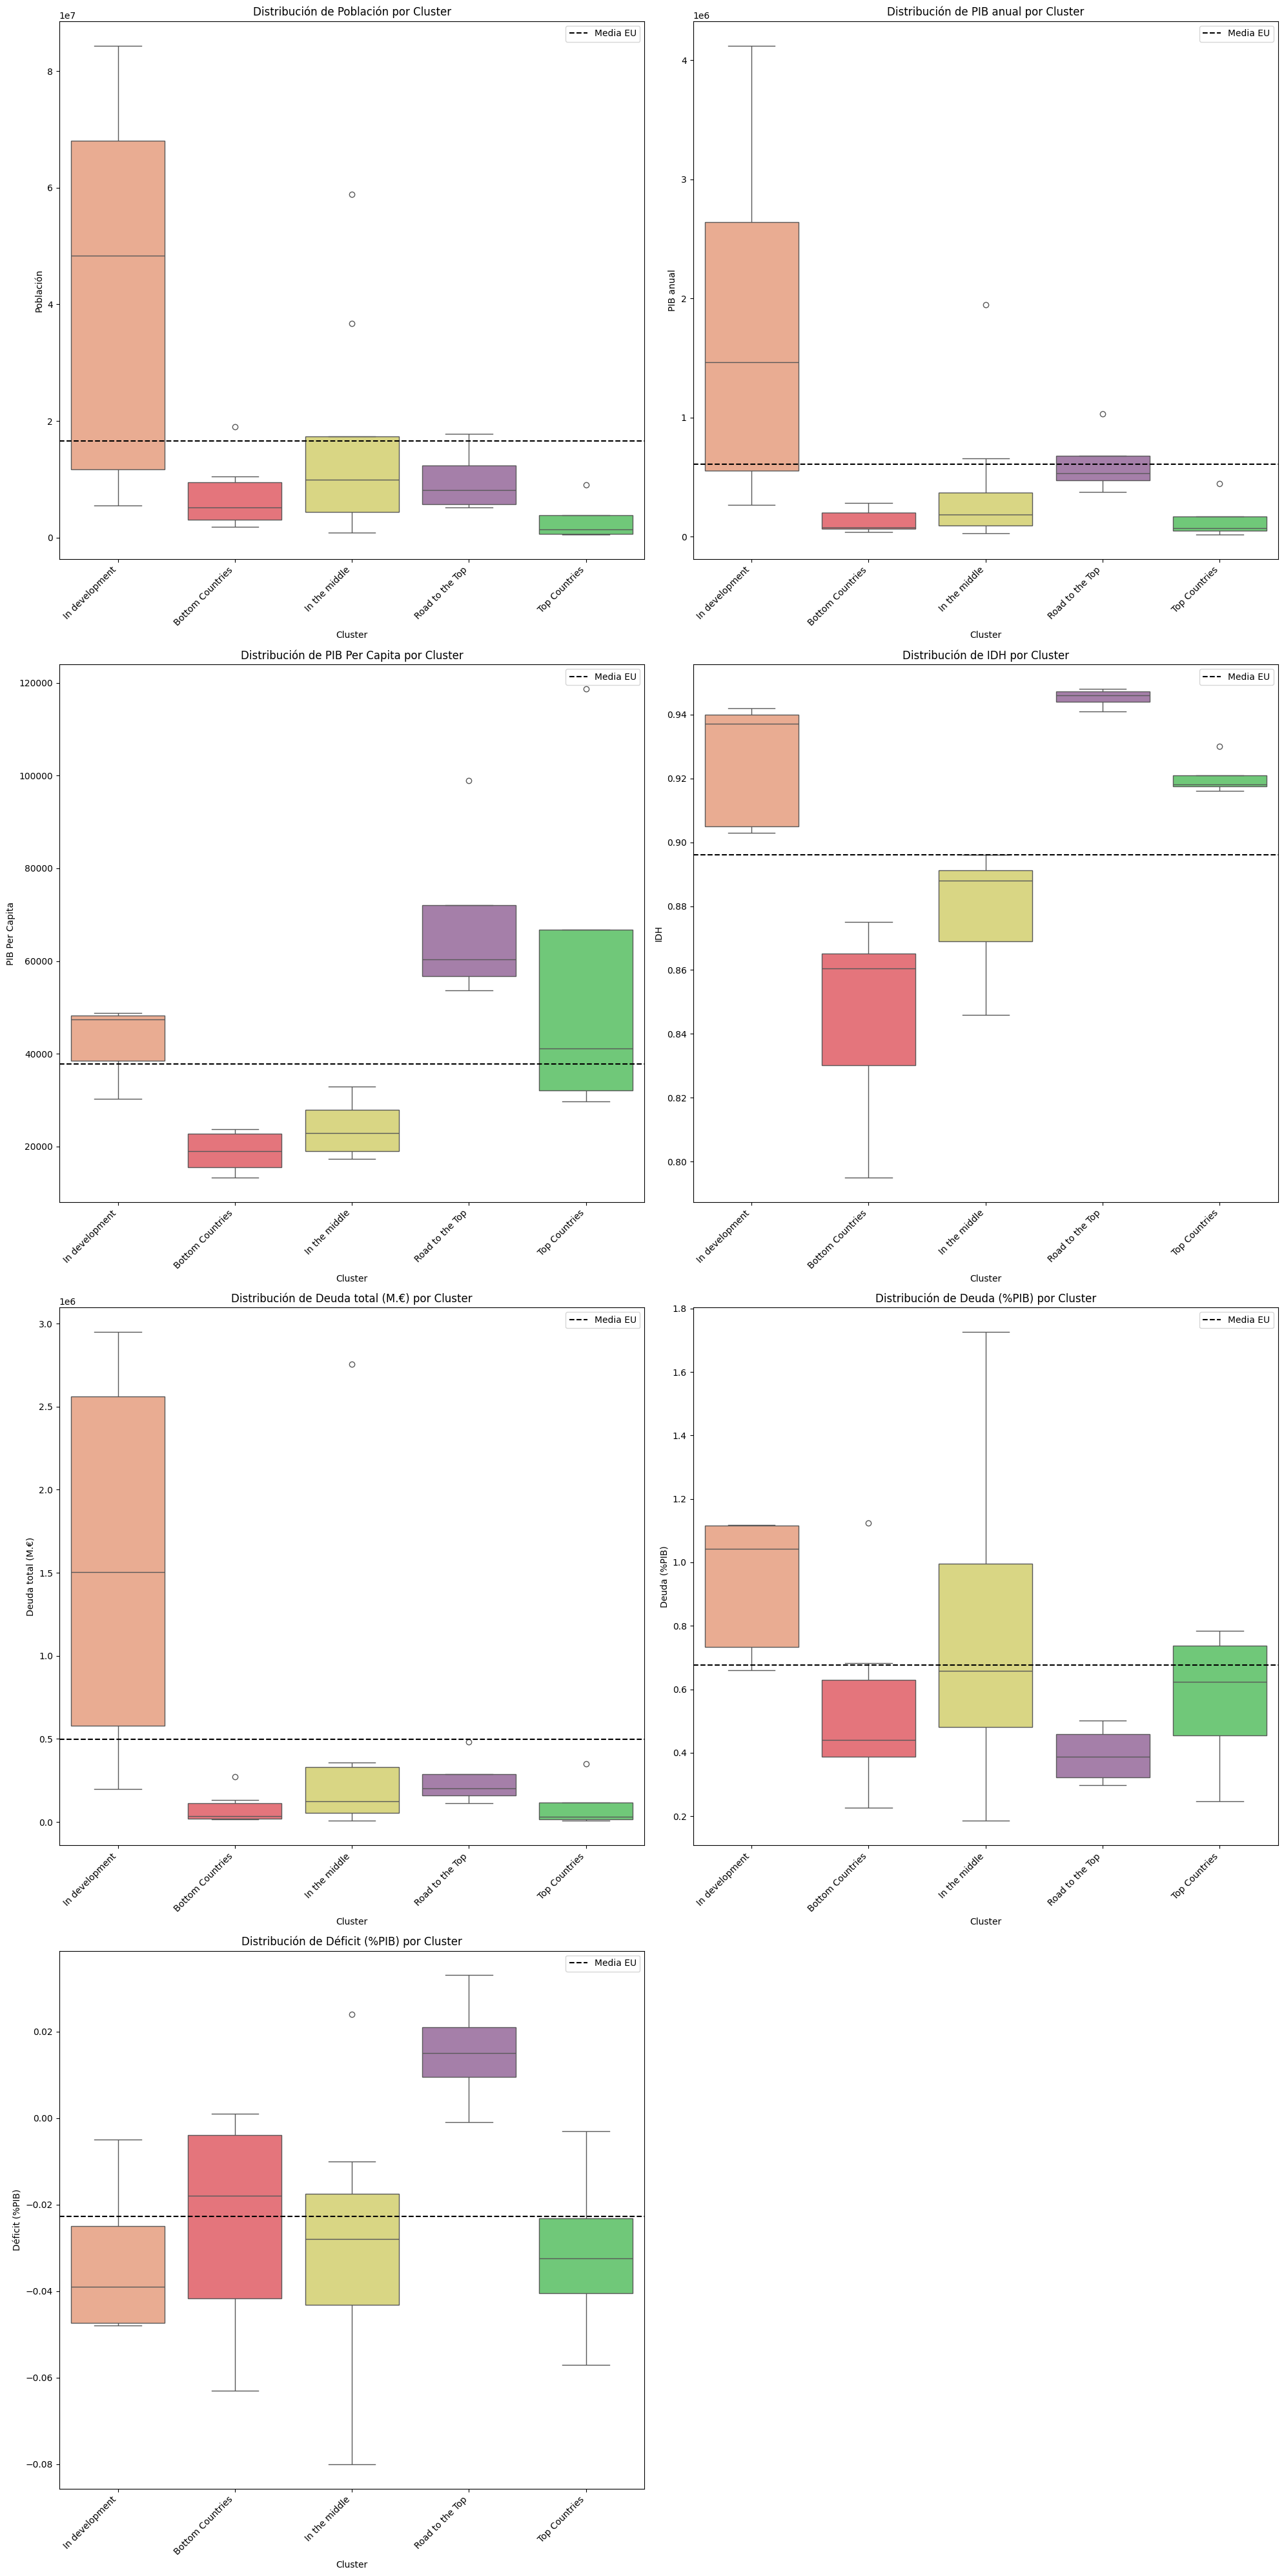

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calcular medias de todas las variables por cluster
mean_metrics_by_cluster = df_combined.groupby('cluster')[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']].mean()

# Extraer las medias para el cluster 'EU'
eu_means = mean_metrics_by_cluster.loc['EU'] if 'EU' in mean_metrics_by_cluster.index else df_combined[['Población', 'PIB anual', 'PIB Per Capita', 'IDH', 'Deuda total (M.€)', 'Deuda (%PIB)', 'Déficit (%PIB)']].mean()

# Filtrar el DataFrame para excluir el cluster 'EU'
df_filtered = df_combined[df_combined['cluster'] != 'EU']

cluster_colors = {
    'In development':"#F8A683" ,
    'In the middle':"#E7E376",
    'Bottom Countries':"#F7626C" ,
    'Top Countries':"#61D76D" ,
    'Road to the Top': "#AB78B0" ,
}

# Ajustar a 2 columnas
cols = 2
# Calcular el número de filas basado en la cantidad de variables a graficar
rows = (len(mean_metrics_by_cluster.columns) + cols - 1) // cols

# Ajustar el tamaño de la figura para acomodar los gráficos más grandes en menos columnas
fig, ax = plt.subplots(rows, cols, figsize=(20, 10 * rows))  # Ajusta el tamaño según necesites

for i, column in enumerate(mean_metrics_by_cluster.columns):
    row = i // cols
    col = i % cols
    sns.boxplot(x='cluster', y=column, data=df_filtered, ax=ax[row, col], palette=cluster_colors)
    # Añadir una línea transversal para la media de 'EU'
    ax[row, col].axhline(y=eu_means[column], color='k', linestyle='--', label='Media EU')
    ax[row, col].set_title(f'Distribución de {column} por Cluster')
    ax[row, col].set_xlabel('Cluster')
    ax[row, col].set_ylabel(column)
    ax[row, col].legend()
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=45, ha="right")  # Ajusta el ángulo según necesites

# Ocultar subplots vacíos si los hay
for j in range(i+1, rows*cols):
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()


In [186]:
# Correlación entre variables
correlacion = df_combined.corr()

ValueError: could not convert string to float: 'BE'

In [185]:
df_combined.corr()

ValueError: could not convert string to float: 'BE'

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación entre variables
correlacion = df_combined.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

ValueError: could not convert string to float: 'BE'

## **4. ANÁLISIS CLUSTERS POR EL DESCRIBE DE LAS VARIABLES PRINCIPALES**

La agrupación es más complicada de visualizar al añadir tantos datos

La información es prácticamente la misma que viendo solo el valor de la variable al extraer el dataset del modelo KMEAN

In [188]:
df_agrupar_final = df_index

In [189]:
distribucion = df_agrupar_final.groupby(['cluster', 'ID_Country']).size().unstack(fill_value=0)
print(distribucion)


ID_Country  AT  BE  BG  CY  CZ  DE  DK  EE  ES  FI  ...  LU  LV  MT  NL  PL  \
cluster                                             ...                       
0            0   1   0   0   0   1   0   0   1   1  ...   0   0   0   0   0   
1            0   0   0   1   1   0   0   1   0   0  ...   0   0   0   0   1   
2            0   0   1   0   0   0   0   0   0   0  ...   0   1   0   0   0   
3            1   0   0   0   0   0   0   0   0   0  ...   1   0   1   0   0   
4            0   0   0   0   0   0   1   0   0   0  ...   0   0   0   1   0   

ID_Country  PT  RO  SE  SI  SK  
cluster                         
0            0   0   0   0   0  
1            0   0   0   0   1  
2            1   1   0   0   0  
3            0   0   0   1   0  
4            0   0   1   0   0  

[5 rows x 27 columns]


In [190]:
ficha_df = pd.DataFrame()

In [ ]:
# variable_to_group

In [191]:
columnas_analizar = df_agrupar_final.columns
columnas_analizar

Index(['ID_Country', 'WORK', 'MONEY', 'KNOWLEDGE', 'TIME', 'POWER', 'HEALTH',
       'cluster'],
      dtype='object')

In [193]:
# ESCOGEMOS LAS PRINCIPALES COLUMNAS CREEMOS NOS PUEDEN INTERESAR VER LA DISTRIBUCION
# for i, col in enumerate(['GEI','FTE','ARP','LEIAVAB']):

for i, col in enumerate(['WORK', 'MONEY', 'KNOWLEDGE', 'TIME', 'POWER','HEALTH']):
    resumen_data = df_agrupar_final[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)
ficha_df.head(10)

cluster             0          1          2          3          4          0  \
WORK  mean  74.117764  67.466673  71.281794  75.957069  79.407908        NaN   
      std    1.248904   2.822949   2.914690   1.745742   2.707999        NaN   
      min   72.866633  63.233541  67.291435  73.399299  76.476623        NaN   
      25%   73.212865  66.258230  69.354736  75.568260  78.125947        NaN   
      50%   73.597156  67.191048  71.531281  76.634226  79.080133        NaN   
      75%   75.427351  68.081269  73.746289  77.023034  80.362094        NaN   
      max   75.484814  72.673982  74.222922  77.160524  82.994741        NaN   
MONEY mean        NaN        NaN        NaN        NaN        NaN  84.843390   
      std         NaN        NaN        NaN        NaN        NaN   4.231746   
      min         NaN        NaN        NaN        NaN        NaN  78.709413   

cluster             1          2          3          4  ...   0   1   2   3  \
WORK  mean        NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      std         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      min         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      25%         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      50%         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      75%         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
      max         NaN        NaN        NaN        NaN  ... NaN NaN NaN NaN   
MONEY mean  76.955659  70.634198  86.901092  87.126046  ... NaN NaN NaN NaN   
      std    3.736220   3.523007   4.208337   1.144874  ... NaN NaN NaN NaN   
      min   72.847121  65.040323  83.583651  85.895786  ... NaN NaN NaN NaN   

cluster      4   0   1   2   3   4  
WORK  mean NaN NaN NaN NaN NaN NaN  
      std  NaN NaN NaN NaN NaN NaN  
      min  NaN NaN NaN NaN NaN NaN  
      25%  NaN NaN NaN NaN NaN NaN  
      50%  NaN NaN NaN NaN NaN NaN  
      75%  NaN NaN NaN NaN NaN NaN  
      max  NaN NaN NaN NaN NaN NaN  
MONEY mean NaN NaN NaN NaN NaN NaN  
      std  NaN NaN NaN NaN NaN NaN  
      min  NaN NaN NaN NaN NaN NaN  

[10 rows x 30 columns]

In [ ]:
# generamos nuestro multiindex
out_index = [
    # "gei",
    "work",
    "money",
    "knowleadge",
    "time",
    "power",
    'health',

]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi in zip(out_index):
    for es in estadisticos:
        new_multi_index.append((oi, es))

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = df_agrupar_final.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
tamaño_clusters

,cluster,0,1,2,3,4
Grupo Indicadores,Estadístico,,,,,
Clúster,Tamaño,7,4,7,5,4


In [ ]:
ficha_df

cluster                                0          1          2          3  \
Grupo Indicadores Estadístico                                               
(work,)           Media        71.480678  75.100915  66.722772  78.611796   
                  Desviación    2.712268   2.284000   2.032794   2.944301   
                  Mínimo       67.291435  72.866633  63.233541  75.427351   
                  Perc. 25     69.455863  73.266132  66.028856  76.476623   
                  Perc. 50     72.673982  75.188252  67.052387  78.675722   
                  Perc. 75     73.632341  77.023034  67.399609  79.484545   
                  Máximo       74.222922  77.160524  69.916547  82.994741   
(money,)          Media        71.057915  84.609313  77.435008  87.201689   
                  Desviación    3.405839   1.934662   3.760497   1.005814   
                  Mínimo       65.040323  83.457074  72.847121  85.895786   
                  Perc. 25     69.775361  83.552007  74.297328  86.569211   
                  Perc. 50     70.361558  83.741132  78.121821  87.504260   
                  Perc. 75     73.870868  84.798439  79.714314  87.513756   
                  Máximo       74.711069  87.497915  83.052828  88.525433   
(knowleadge,)     Media        54.458602  59.967150  58.205233  68.104492   
                  Desviación    3.602202   5.392064   1.702053   4.694027   
                  Mínimo       47.716864  54.666322  55.778916  61.519285   
                  Perc. 25     52.818810  55.677111  57.282438  66.968172   
                  Perc. 50     56.197061  60.012635  57.785274  68.110555   
                  Perc. 75     57.044909  64.302674  59.192688  69.343523   
                  Máximo       57.568848  65.177009  60.922184  74.580922   
(time,)           Media        54.649065  65.828055  52.237437  81.713358   
                  Desviación   11.321423   4.975660   5.363624   6.178415   
                  Mínimo       42.653851  61.191437  44.734442  74.156330   
                  Perc. 25     48.909396  63.472043  48.764338  77.365551   
                  Perc. 50     50.565897  64.625951  52.496322  83.093783   
                  Perc. 75     58.409290  66.981963  55.803058  83.861729   
                  Máximo       74.686339  72.868881  59.296505  90.089399   
(power,)          Media        47.306738  52.552462  33.730663  71.753196   
                  Desviación   11.012619   9.996880  10.611703   8.483114   
                  Mínimo       32.615388  40.378974  24.831664  61.663979   
                  Perc. 25     39.711380  48.878924  29.244236  68.940694   
                  Perc. 50     49.723753  52.508394  30.085176  69.256244   
                  Perc. 75     53.197868  56.181931  32.903807  74.287453   
                  Máximo       62.989528  64.814086  56.901715  84.617613   
(health,)         Media        80.725033  89.026001  86.115302  93.304736   
                  Desviación    5.342423   2.006638   1.787920   2.339425   
                  Mínimo       70.399835  86.924949  83.644513  89.535645   
                  Perc. 25     78.681665  87.611388  85.001459  92.608209   
                  Perc. 50     82.742649  88.927408  85.836255  94.200957   
                  Perc. 75     84.749306  90.342021  87.175672  94.973382   
                  Máximo       85.070806  91.324239  88.972083  95.205487   

cluster                                4  
Grupo Indicadores Estadístico             
(work,)           Media        74.646520  
                  Desviación    1.479233  
                  Mínimo       73.212865  
                  Perc. 25     73.501083  
                  Perc. 50     74.540985  
                  Perc. 75     75.686422  
                  Máximo       76.291247  
(money,)          Media        86.469951  
                  Desviación    6.126080  
                  Mínimo       78.709413  
                  Perc. 25     83.205694  
                  Perc. 50     87.273102  
         

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df = ficha_df.rename(columns = {
    0 : "PEOR",
    1 : "EN LA MEDIA",
    2 : "EN DESARROLLO",
    3 : "MEJORES",
    4 : "CAMINO A SER MEJORES",
})

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)